In [1]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, roc_curve, auc
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import shap
from keras.layers import Input, Dense, Flatten, \
    Concatenate, concatenate, Dropout, Lambda
from keras.models import Model, Sequential
from keras.layers.embeddings import Embedding
import keras
from livelossplot import PlotLossesKeras
import eli5
from eli5.sklearn import PermutationImportance
import scipy
from scipy.cluster import hierarchy as hc
from pdpbox import pdp, get_dataset, info_plots
from lime.lime_tabular import LimeTabularExplainer
import math

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)


shap.initjs()


label_column = "loan"
csv_path = 'data/adult.data'
csv_columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country", "loan"]
input_columns = ["age", "workclass", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country"]
categorical_features = ["workclass", "education", "marital-status",
                       "occupation", "relationship", "ethnicity", "gender",
                       "native-country"]

def prepare_data(df):
    
    if "fnlwgt" in df: del df["fnlwgt"]
    
    tmp_df = df.copy()

    # normalize data (this is important for model convergence)
    dtypes = list(zip(tmp_df.dtypes.index, map(str, tmp_df.dtypes)))
    for k,dtype in dtypes:
        if dtype == "int64":
            tmp_df[k] = tmp_df[k].astype(np.float32)
            tmp_df[k] -= tmp_df[k].mean()
            tmp_df[k] /= tmp_df[k].std()

    cat_columns = tmp_df.select_dtypes(['object']).columns
    tmp_df[cat_columns] = tmp_df[cat_columns].astype('category')
    tmp_df[cat_columns] = tmp_df[cat_columns].apply(lambda x: x.cat.codes)
    tmp_df[cat_columns] = tmp_df[cat_columns].astype('int8')
    
    return tmp_df

def get_dataset_1():
    tmp_df = df.copy()
    tmp_df = tmp_df.groupby('loan') \
                .apply(lambda x: x.sample(100) if x["loan"].iloc[0] else x) \
                .reset_index(drop=True)
    
    X = tmp_df.drop(label_column, axis=1).copy()
    y = tmp_df[label_column].astype(int).values.copy()
    
    return tmp_df, df_display.copy()

def get_production_dataset():
    tmp_df = df.copy()
    
    X = tmp_df.drop(label_column, axis=1).copy()
    y = tmp_df[label_column].astype(int).values.copy()
    
    X_train, X_valid, y_train, y_valid = \
        train_test_split(X, y, test_size=0.2, random_state=7)

    return X_valid, y_valid


def get_dataset_2():
    tmp_df = df.copy()
    tmp_df_display = df_display.copy()
    
    X = tmp_df.drop(label_column, axis=1).copy()
    y = tmp_df[label_column].astype(int).values.copy()
    
    X_display = tmp_df_display.drop(label_column, axis=1).copy()
    y_display = tmp_df_display[label_column].astype(int).values.copy()
    
    X_train, X_valid, y_train, y_valid = \
        train_test_split(X, y, test_size=0.2, random_state=7)

    return X, y, X_train, X_valid, y_train, y_valid, X_display, y_display, tmp_df, tmp_df_display
    
df_display = pd.read_csv(csv_path, names=csv_columns)
df_display[label_column] = df_display[label_column].apply(lambda x: ">50K" in x)
df = prepare_data(df_display)

def build_model():
    input_els = []
    encoded_els = []
    dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
    for k,dtype in dtypes:
        input_els.append(Input(shape=(1,)))
        if dtype == "int8":
            e = Flatten()(Embedding(df[k].max()+1, 1)(input_els[-1]))
        else:
            e = input_els[-1]
        encoded_els.append(e)
    encoded_els = concatenate(encoded_els)

    layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
    out = Dense(1, activation='sigmoid')(layer1)

    # train model
    model = Model(inputs=input_els, outputs=[out])
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model

def f_in(X, m=None):
    """Preprocess input so it can be provided to a function"""
    if m:
        return [X.iloc[:m,i] for i in range(X.shape[1])]
    else:
        return [X.iloc[:,i] for i in range(X.shape[1])]

def f_out(probs):
    """Convert probabilities into classes"""
    return list((probs >= 0.5).astype(int).T[0])

def plot_roc(y, probs):
    
    fpr, tpr, _ = roc_curve(y, probs)

    roc_auc = auc(fpr, tpr)
    print(roc_auc)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.rcParams.update(params)
    plt.show()
    
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in list(np.logspace(0.6,4,dtype='int')):
        if m >= len(X_train): break
        model.fit(f_in(X_train,m), y_train[:m], epochs=50, batch_size=512, verbose=0)
        y_train_predict = model.predict(f_in(X_train,m))
        y_val_predict = model.predict(f_in(X_val))
        y_train_predict = f_out(y_train_predict)
        y_val_predict = f_out(y_val_predict)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    
def keras_score(self, X, y, **kwargs):
    """ Scorer class for eli5 library on feature importance"""
    input_test = [X[:,i] for i in range(X.shape[1])]
    loss = self.evaluate(input_test, y)
    if type(loss) is list:
        # The first one is the error, the rest are metrics
        return -loss[0]
    return -loss

class ModelWrapper():
    """ Keras model wrapper to override the predict function"""
    def __init__(self, model):
        self.model = model
    
    def predict(self, X, **kwargs):
        return self.model.predict([X.iloc[:,i] for i in range(X.shape[1])])

def plot_all_features(X):
    fig = plt.figure(figsize=(20,15))
    cols = 5
    rows = math.ceil(float(X.shape[1]) / cols)
    for i, column in enumerate(X.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if X.dtypes[column] == np.object:
            X[column].value_counts().plot(kind="bar", axes=ax)
        else:
            X[column].hist(axes=ax)
            plt.xticks(rotation="vertical")
    plt.subplots_adjust(hspace=0.7, wspace=0.2)
    
def plot_dendogram(corr, X):
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method="average")
    fig = plt.figure(figsize=(16,5))
    dendrogram = hc.dendrogram(
        z, labels=X.columns, orientation="left", leaf_font_size=16)
    plt.show()

Using TensorFlow backend.



<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Explainability and Bias Evaluation<br> with Tensorflow</font></h1> 

<br>
<br>
<br>
<br>
<br>
<br>

<h1>Alejandro Saucedo</h1>
<br>
Chief Scientist, The Institute for Ethical AI & Machine Learning

<br>
<br>

[github.com/ethicalml/bias-analysis](github.com/ethicalml/bias-analysis)


<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">NEW Project!</font></h1> 

<br>
<br>
<br>

## Client wants to automate loan approval process

<br>

#### They have a manual process where a domain expert goes through applicants
They want to automate this as they get 1m requests per month

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Business wants it NOW!</font></h1>

<br>
<br>

## Or yesterday if possible...

<br>
<br>

They heard their competitor is using "Machine Learning" and business says we need to use that

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">We asked for DATA</font></h1> 

<br>
<br>

## They gave us an excel sheet with 25 rows

<br>
<br>

We pushed back, and after a while we finally got a dataset with ~8000 rows

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">And so it begun...</font></h1> 

<img src="images/copypasta.jpg" style="height:50vh">

<br>
<br>

## The journey towards greatness...

In [2]:
df_data, df_display = get_dataset_1()

df_display.head(5)

,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country,loan
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,False
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,False
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,False
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,False
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,False


In [3]:
X = df_data.drop(label_column, axis=1).copy()
y = df_data[label_column].astype(int).values.copy()

X_train, X_valid, y_train, y_valid = \
        train_test_split(X, y, test_size=0.2, random_state=7)

X_train.head(5)

,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country
4532,1.276965,4,9,1.134721,6,8,1,4,0,-0.145918,-0.216656,-0.035429,39
11847,2.596571,4,3,-3.140908,2,14,0,2,1,-0.145918,-0.216656,-1.655199,39
16245,2.963128,4,9,1.134721,2,12,0,4,1,-0.145918,-0.216656,-0.035429,39
11203,2.083391,2,12,1.523415,0,1,1,4,0,0.126109,-0.216656,-0.035429,39
19215,-1.069002,4,11,-0.420053,4,14,4,2,1,-0.145918,-0.216656,-0.035429,39


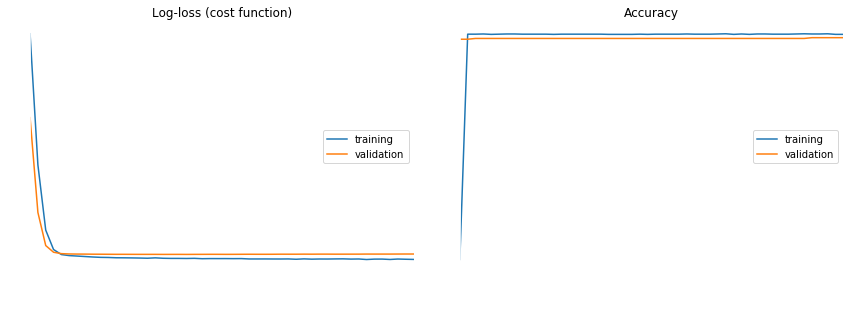

Log-loss (cost function):
training   (min:    0.017, max:    0.469, cur:    0.018)
validation (min:    0.028, max:    0.302, cur:    0.028)

Accuracy:
training   (min:    0.938, max:    0.996, cur:    0.996)
validation (min:    0.995, max:    0.995, cur:    0.995)


In [4]:
# 1 layer, 100 neurons model, with softmax
model = build_model()

model.fit(f_in(X_train), y_train, epochs=50,
    batch_size=512, shuffle=True, validation_data=(f_in(X_valid), y_valid),
    callbacks=[PlotLossesKeras()], verbose=0, validation_split=0.05,)

In [5]:
score = model.evaluate(f_in(X_valid), y_valid, verbose=1)
print("Error %.4f: " % score[0])
print("Accuracy %.4f: " % (score[1]*100))

4964/4964 [==============================] - 0s 18us/step
Error 0.0284: 
Accuracy 99.5367: 


<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">It's PROD-TIME!</font></h1> 

<br>
<br>
<br>
<br>

### Accuracy is 98% - How lucky are we!

<br>
<br>
<br>

##### Press the button?


<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">2am emergency call...</font></h1> 


...what do you mean performing terrible? We followed the instructions!

<br>

<img src="images/layer.jpg" style="height: 50vh">


<br>


# Time to REVERT!



In [6]:
X_prod, y_prod = get_production_dataset()

score = model.evaluate(f_in(X_prod), y_prod, verbose=1)

print("Error %.4f: " % score[0])
print("Accuracy %.4f: " % (score[1]*100))

6513/6513 [==============================] - 0s 17us/step
Error 1.0408: 
Accuracy 77.1841: 


In [7]:
probabilities = model.predict(f_in(X_valid))
print(list(probabilities.T[0])[:10])

pred = f_out(probabilities)
print(pred[:10])

[9.9493314e-05, 4.0452815e-06, 1.5298654e-06, 1.8363407e-05, 7.307595e-05, 8.008075e-05, 0.004870913, 4.0102223e-05, 0.009694976, 7.195043e-05]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


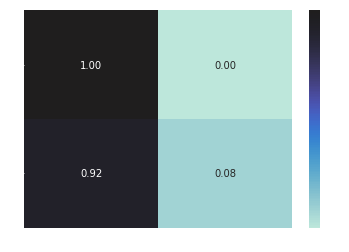

In [8]:
confusion = sklearn.metrics.confusion_matrix(y_valid, pred)
confusion_scaled = confusion.astype("float") / confusion.sum(axis=1)[:, np.newaxis]
confusion_scaled_df = pd.DataFrame(confusion_scaled, index=["Denied", "Approved"], columns=["Denied", "Approved"])
sn.heatmap(confusion_scaled_df, annot=True, fmt='.2f', center=1)

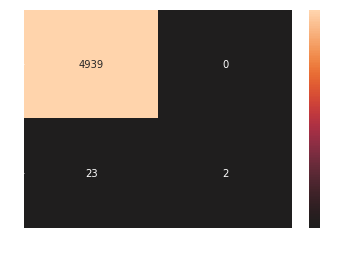

In [9]:
confusion_df = pd.DataFrame(confusion,
            index=["Actual Denied", "Actual Approved"], 
            columns=["Preditced Denied", "Preditced Approved"])

sn.heatmap(confusion_df, annot=True, fmt='d', center=1)

In [10]:
print(sklearn.metrics.classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4939
           1       1.00      0.08      0.15        25

   micro avg       1.00      1.00      1.00      4964
   macro avg       1.00      0.54      0.57      4964
weighted avg       1.00      1.00      0.99      4964



0.54


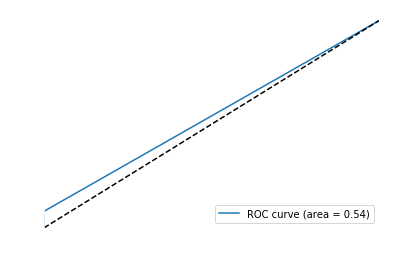

In [11]:
plot_roc(y_valid, pred)

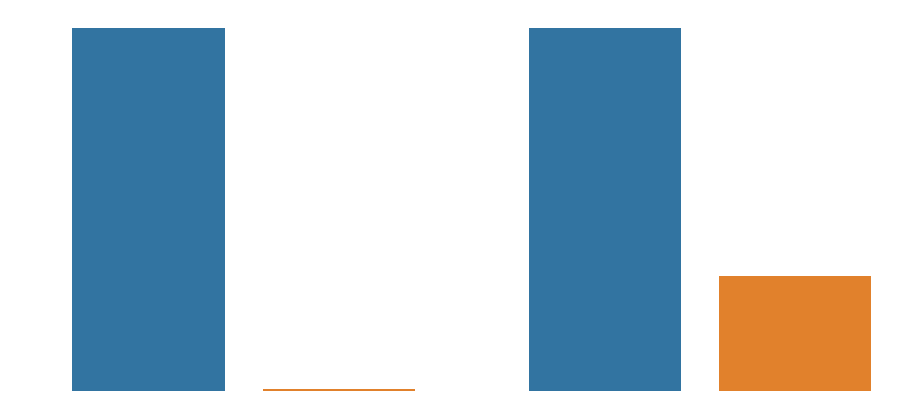

In [12]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
sn.countplot(y_valid, ax=ax[0]) 
sn.countplot(y_prod, ax=ax[1]) 

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Bias</font></h1>

<br>
<br>
<br>
<br>

Any non trivial decision (i.e. more than 1 option) holds a bias, without exceptions.


<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Defining bias as two interacting challenges</font></h1>

>> Important word: "Interacting"

<br>

## Constraints bias (bias a-priori)

* Encompases the constraints that limit the project
* Often also refered to as "prejudice" or "societal bias"
* The error difference between the ultimate ideal solution and the optimal possible

<br>
<br>

## Statistical bias (bias a-posteriori)

* Encompases constraints introduced from decisions on the design and development
* The error difference between the optimal possible outcome and our current


<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Constraint bias / a-priori</font></h1>

* Lack of understanding of the project

<br>

* Incomplete resources (data collection, time, domain experts, etc)

<br>

* Incorrectly labelled data (accident vs otherwise)

<br>

* Sub-optimal objectives

<br>

* Lack of relevant skillset

<br>

* Societal shifts in perception

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Bias assessment is hard</font></h1>

But fortunately not a new challenge. We just need to bridge the gaps.


<img src="images/chart.png" style="height:30vw;margin-left: 10vw; float: left; background-color: transparent">
<img src="images/chart-more.png" style="height:30vw; margin-left: 10vw; float: left;  background-color: transparent">


<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Bridging gaps</font></h1>

<br>
<br>
<br>
<br>
<br>
<br>
<br>

### A large ethical decision should not just fall on the shoulders of a single engineer

<br>
<br>


Cross functional work is key - bringing the right expertise at the right time


<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">From research to industry</font></h1>

<img src="images/corpora.png" style="width=100vw">

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Statistical bias / a-posteriori</font></h1>

* Process decisions to not include a human-in-the-loop (or partial human review) 

<br>

* Sub-optimal choices of accuracy metrics / cost functions

<br>

* Sub-optimal choices on the machine learning models and hyperparameters

<br>

* Lack of reasonable effort to built the required infrastructure

<br>

* Not using resources at disposal (e.g. domain experts, tools, etc).

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Starting from the fundamentals</font></h1>

<img src="images/mlall.png" style="width=100vw">

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Augmenting the data science workflow</font></h1>

<img src="images/gml.png" style="width=100vw">

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Iterative improvement</font></h1>

<br>
<br>
<br>
<br>
<br>
<br>
<br>

### As the process is carried out, new knowledge is discovered

<br>
<br>


This allows for the right decisions to be made consciously


<img src="images/bias1.jpg" style="height:80vh">

<img src="images/bias2.jpg" style="height:80vh">

<img src="images/bias3.jpg" style="height:80vh">

<img src="images/bias4.jpg" style="height:80vh">

<img src="images/bias5.jpg" style="height:80vh">

# Data Analysis

In [13]:
X, y, X_train, X_valid, y_train, y_valid, X_display, y_display, df, df_display \
    = get_dataset_2()
X.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country
0,0.030670,7,9,1.134721,4,1,1,4,1,0.148451,-0.216656,-0.035429,39
1,0.837096,6,9,1.134721,2,4,0,4,1,-0.145918,-0.216656,-2.222119,39
2,-0.042641,4,11,-0.420053,0,6,1,4,1,-0.145918,-0.216656,-0.035429,39
3,1.057031,4,1,-1.197440,2,6,0,2,1,-0.145918,-0.216656,-0.035429,39
4,-0.775756,4,9,1.134721,2,10,5,2,0,-0.145918,-0.216656,-0.035429,5


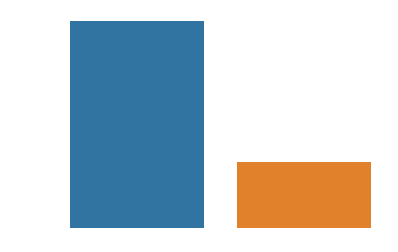

In [14]:
sn.countplot(y_valid) 

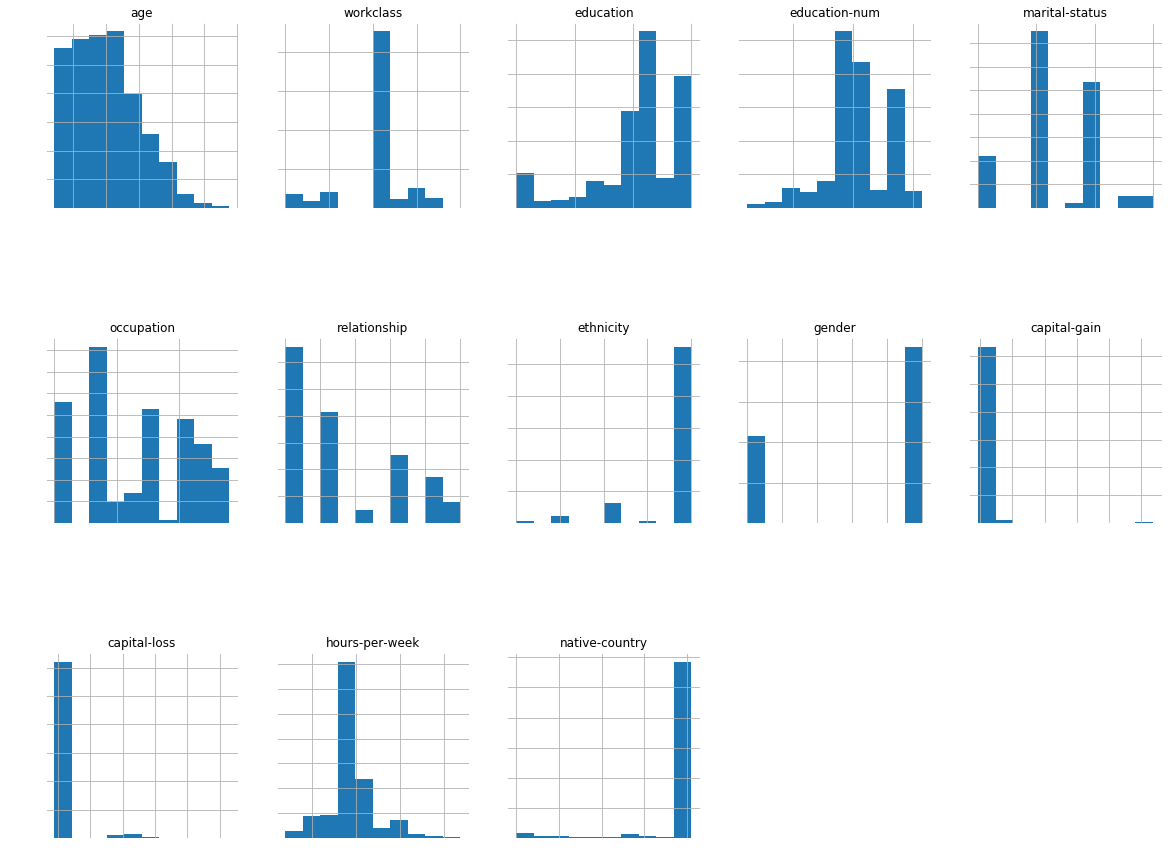

In [15]:
plot_all_features(X)

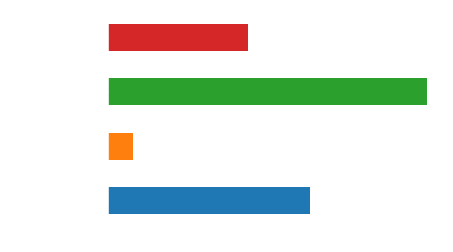

In [16]:
df_display.groupby(["gender", "loan"]).size().plot.barh()

In [17]:
flds = ["gender", "age", "education-num", "capital-gain", 
                  "capital-loss", "hours-per-week"]


enc_summ = X_display[flds].groupby("gender", as_index=False).mean()
enc_summ

,gender,age,education-num,capital-gain,capital-loss,hours-per-week
0,Female,36.858230,10.035744,568.410547,61.187633,36.410361
1,Male,39.433547,10.102891,1329.370078,100.213309,42.428086


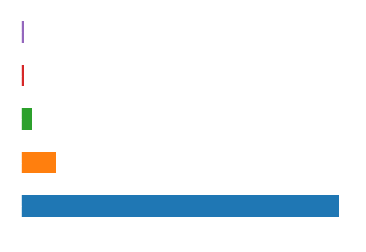

In [18]:
df["ethnicity"].value_counts().plot.barh()

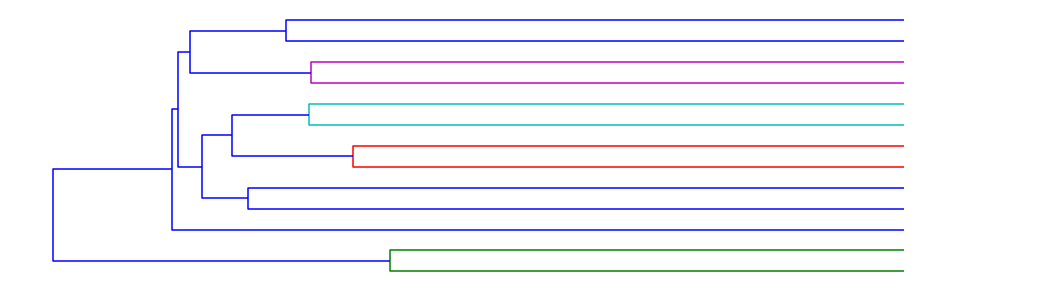

In [19]:
corr = np.round(scipy.stats.spearmanr(X_display).correlation, 4)
plot_dendogram(corr, X)

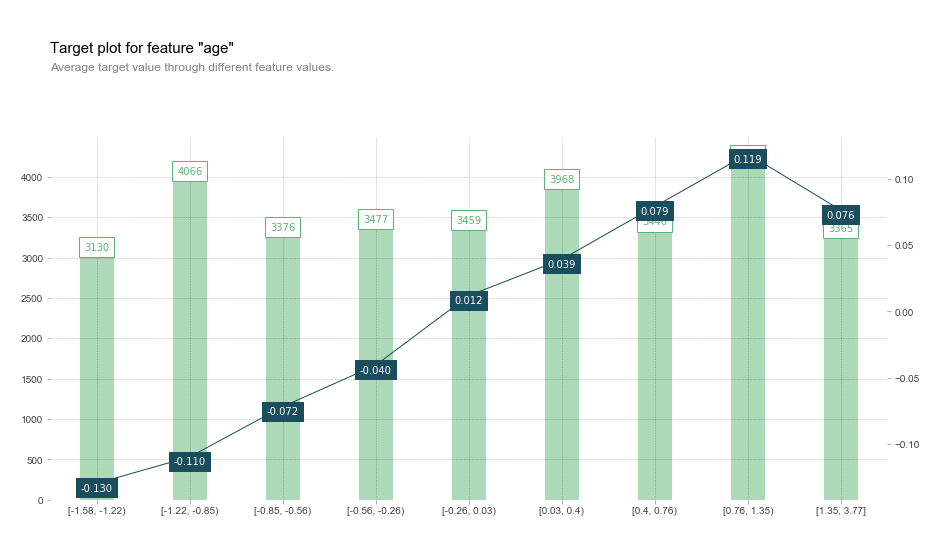

In [20]:
fig, axes, summary_df = info_plots.target_plot(
    df=df, feature="age", feature_name="age", target="capital-gain")

# Model analysis

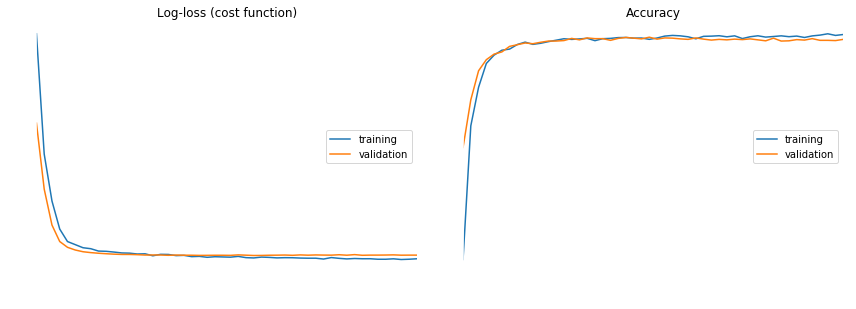

Log-loss (cost function):
training   (min:    0.306, max:    0.583, cur:    0.307)
validation (min:    0.311, max:    0.474, cur:    0.312)

Accuracy:
training   (min:    0.716, max:    0.859, cur:    0.859)
validation (min:    0.787, max:    0.857, cur:    0.856)


In [21]:
# 1 layer, 100 neurons model, with softmax
model = build_model()
model.fit(f_in(X_train), y_train, epochs=50, batch_size=512, shuffle=True, validation_data=(f_in(X_valid), y_valid), callbacks=[PlotLossesKeras()], verbose=0, validation_split=0.05,)
probabilities = model.predict(f_in(X_valid))
pred = f_out(probabilities)

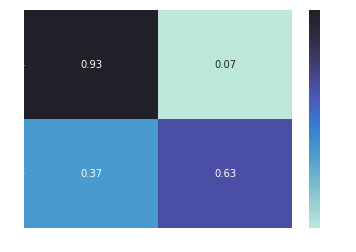

In [22]:
confusion = sklearn.metrics.confusion_matrix(y_valid, pred)
confusion_scaled = confusion.astype("float") / confusion.sum(axis=1)[:, np.newaxis]
confusion_scaled_df = pd.DataFrame(confusion_scaled, index=["Denied", "Approved"], columns=["Denied", "Approved"])
sn.heatmap(confusion_scaled_df, annot=True, fmt='.2f', center=1)

0.7775460718627698


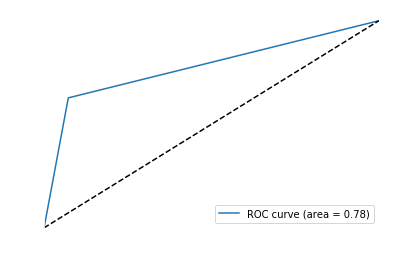

In [23]:
plot_roc(y_valid, pred)

In [24]:
perm = PermutationImportance(model, random_state=1, scoring=keras_score).fit(X,y)

32561/32561 [==============================] - 1s 15us/step


In [25]:
eli5_fi = eli5.explain_weights_df(perm, feature_names = X.columns.tolist())
eli5_fi

,feature,weight,std
0,capital-gain,0.142965,0.001019
1,marital-status,0.065205,0.000797
2,education-num,0.045078,0.001608
3,age,0.042204,0.000914
4,occupation,0.026463,0.000637
5,hours-per-week,0.022900,0.000795
6,relationship,0.021345,0.000828
7,gender,0.011749,0.000901
8,capital-loss,0.009098,0.000363
9,workclass,0.003256,0.000219


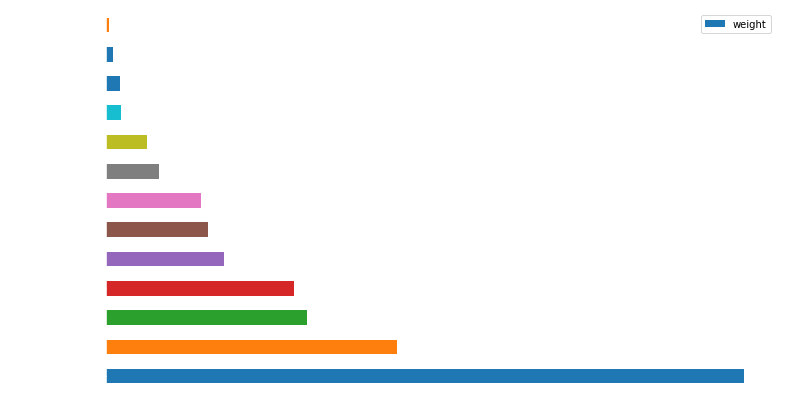

In [26]:
eli5_fi.plot("feature", "weight", "barh", figsize=(12,7))

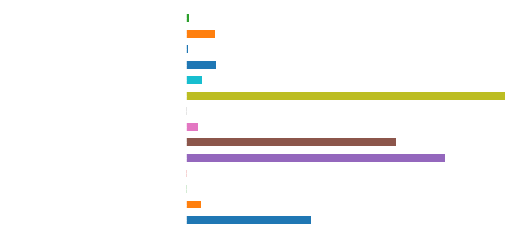

In [27]:
df_display.groupby(["marital-status", "loan"]).size().plot("barh")

# SHAP

In [28]:
def shap_predict(X):
    values = model.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    return values

shap_explainer = shap.KernelExplainer(shap_predict, X.iloc[:100,:])

In [29]:
shap_idx = 0
shap_x = X.iloc[shap_idx,:]
shap_display_x = X_display.iloc[shap_idx,:]
shap_values = shap_explainer.shap_values(shap_x, nsamples=500)

Probability:  [0.08586023]


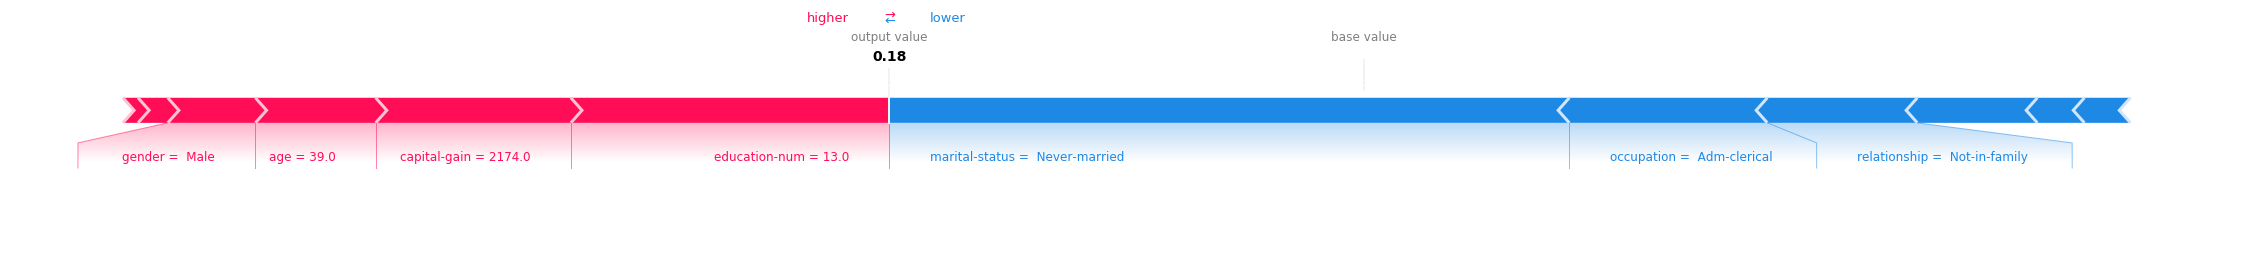

In [30]:
print("Probability: ", probabilities[shap_idx])
shap.force_plot(shap_explainer.expected_value, shap_values, shap_display_x, matplotlib=True, figsize=(40, 3))

In [31]:
shap_idx_multi_from = 15
shap_idx_multi_to = 40

shap_x_multi = X.iloc[shap_idx_multi_from:shap_idx_multi_to,:]
shap_display_multi = X_display.iloc[shap_idx_multi_from:shap_idx_multi_to,:]
shap_y_multi = y[shap_idx_multi_from:shap_idx_multi_to]

In [32]:
shap_values_multi = shap_explainer.shap_values(shap_x_multi, nsamples=500)

100%|██████████| 25/25 [00:22<00:00,  1.07it/s]


In [33]:
shap.force_plot(shap_explainer.expected_value, shap_values_multi, shap_display_multi)

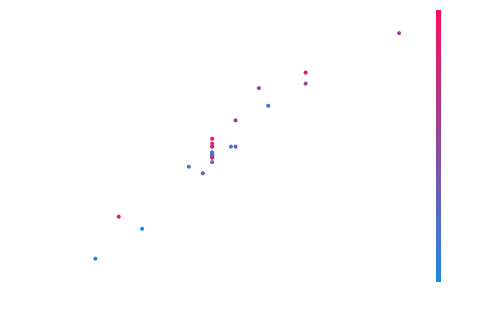

In [34]:
shap.dependence_plot("hours-per-week", 
                     shap_values_multi, 
                     shap_x_multi, 
                     display_features=shap_display_multi,
                     axis_color='#FFFFFF')

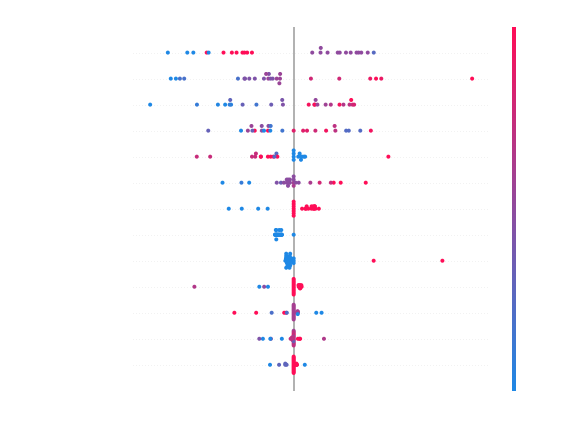

In [35]:
shap.summary_plot(shap_values_multi, shap_x_multi, axis_color='#FFFFFF')

# Lime

In [36]:
tf_lime_explainer = LimeTabularExplainer(
                X_train.values,
                feature_names=list(X_train.columns),
                categorical_features=categorical_features)

In [37]:
def lime_predict_proba(X):
    values = model.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    prob_pairs = np.array([1-values, values]).T
    return prob_pairs

tf_lime_explanation = tf_lime_explainer.explain_instance(
        X_train.iloc[1,:], lime_predict_proba, num_features=13) 

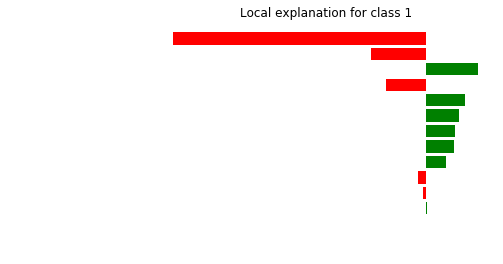

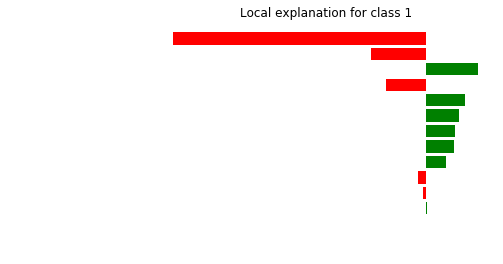

In [38]:
tf_lime_explanation.as_pyplot_figure()

In [39]:
tf_lime_explanation.show_in_notebook(show_table=True, show_all=True)

# Learning curves

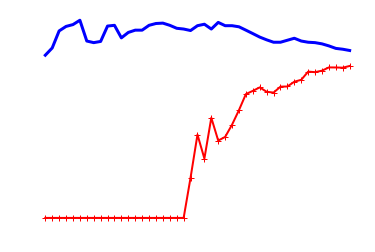

In [40]:
plot_learning_curves(model, X_valid, y_valid)

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Revisiting our workflow</font></h1>

<img src="images/gml.png" style="width=100vw">


<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Explainability and Bias Evaluation<br> with Tensorflow</font></h1> 

<br>
<br>
<br>
<br>
<br>
<br>

<h1>Alejandro Saucedo</h1>
<br>
Chief Scientist, The Institute for Ethical AI & Machine Learning

<br>
<br>

[github.com/ethicalml/bias-analysis](github.com/ethicalml/bias-analysis)
